# Convolution Neural Networks

In [2]:
#| default_exp models.conv

In [3]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [3]:
#| export
import torch.nn as nn
import torch

from lightning import LightningModule, Trainer
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from lightning.pytorch.tuner.tuning import Tuner
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

from torch_lr_finder import LRFinder
from torchinfo import summary

from hydra.utils import instantiate
from omegaconf import OmegaConf

from matplotlib import pyplot as plt
import pandas as pd
from typing import List, Optional, Type

from nimrod.utils import get_device, set_seed
from nimrod.models.core import Classifier

from pprint import pprint
import logging


In [4]:
#| export
logger = logging.getLogger(__name__)
set_seed()

Seed set to 42


## Conv filters

In [6]:
#| notest
cfg = OmegaConf.load('../config/data/image/mnist.yaml')
dm = instantiate(cfg)
dm.prepare_data()
dm.setup()

[13:49:28] INFO - PyTorch version 2.5.1 available.
Seed set to 42
[13:49:29] INFO - Init ImageDataModule for mnist
[13:49:44] INFO - split train into train/val [0.8, 0.2]
[13:49:44] INFO - train: 48000 val: 12000, test: 10000


torch.Size([1, 28, 28])


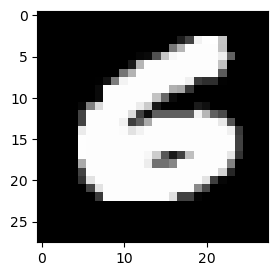

In [7]:
#| notest
x, y = dm.train_ds[0]
print(x.shape)
plt.figure(figsize=(3,3))
plt.imshow(x.squeeze(), cmap='gray')

In [37]:
top_kernel = torch.tensor( # torch.tensor infers datatype vs. torch.Tensor
    [[-1., -1., -1.],
     [0., 0., 0.],
     [1., 1., 1.]]
)

bottom_kernel = torch.tensor( # torch.tensor infers datatype vs. torch.Tensor
    [[1., 1., 1.],
     [0., 0., 0.],
     [-1., -1., -1.]]
)

left_kernel = torch.tensor( # torch.tensor infers datatype vs. torch.Tensor
    [[-1., 0., 1.],
     [-1., 0., 1.],
     [-1., 0., 1.]]
)

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])


Text(0.5, 1.0, 'Convolution transpose')

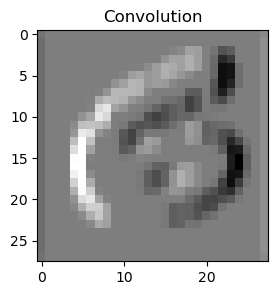

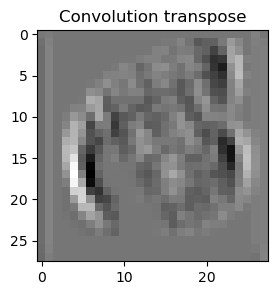

In [66]:
#| notest

my_kernel = left_kernel

c = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
with torch.no_grad():
    c.weight.copy_(my_kernel)

print(x.shape)
y = c(x)
print(y.shape)
plt.figure(figsize=(3,3))
plt.imshow(y.squeeze().detach(), cmap='gray')
plt.title('Convolution')

dc = nn.ConvTranspose2d(1, 1, kernel_size=3, padding=1, bias=False)
# with torch.no_grad():
#     dc.weight.copy_(my_kernel)

x_bar = dc(y)
print(x_bar.shape)
plt.figure(figsize=(3,3))
plt.imshow(x_bar.squeeze().detach(), cmap='gray')
plt.title('Convolution transpose')

## Conv Layer

Using a convolution with a stride of 2 instead of max pooling essentially achieves the same goal of downsampling an image by reducing its spatial dimensions, but with the key difference that the convolution layer can learn more complex feature combinations from overlapping regions, while max pooling only selects the maximum value within a window, potentially losing information about the finer details within that region; making the convolution with stride approach often preferred for preserving more spatial information in a neural network. 

In [39]:
#| export

class ConvLayer(nn.Module):
    """A 2D convolutional layer with optional batch normalization and activation.

    This layer performs 2D convolution with stride 2 for downsampling, optionally followed by
    batch normalization and activation.

    Parameters
    ----------
    in_channels : int, default=3
        Number of input channels
    out_channels : int, default=16 
        Number of output channels / number of features
    kernel_size : int, default=3
        Size of the convolving kernel
    bias : bool, default=True
        If True, adds a learnable bias to the convolution
    normalization : nn.Module, default=nn.BatchNorm2d
        Normalization layer to use after convolution
    activation : nn.Module, default=nn.ReLU
        Activation function to use after normalization

    Notes
    -----
    When using batch normalization, the convolution bias is automatically disabled
    since it would be redundant.

    The spatial dimensions are reduced by half due to stride=2 convolution:
    output_size = input_size/2
    """
  
    def __init__(
        self,
        in_channels:int=3, # input channels
        out_channels:int=16, # output channels
        kernel_size:int=3, # kernel size
        stride:int=2, # stride
        bias:bool=True,
        normalization:Optional[Type[nn.Module]]=nn.BatchNorm2d,
        activation:Optional[Type[nn.Module]]=nn.ReLU,
        
    ):

        super().__init__()
        
        if bias and normalization and issubclass(normalization, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d)):
            logger.warning('setting conv bias to False as Batchnorm is used')
            # https://x.com/karpathy/status/1013245864570073090
            bias = None

        # use stride 2 for downsampling to (W/2, H/2) instead of max or average pooling with stride 1
        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=kernel_size//2,
            bias=bias
            )
        layers = [conv]
        if normalization:
            if issubclass(normalization,  (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
                layers.append(normalization(out_channels))
        if activation:
            layers.append(activation())
        self.net = nn.Sequential(*layers)

    def forward(
            self,
            x:torch.Tensor # input image tensor of dimension (B, C, W, H)
            ) -> torch.Tensor: # output image tensor of dimension (B, C, W/2, H/2)
        
        """forward method of the ConvLayer"""
        return self.net(x)


In [ ]:
show_doc(ConvLayer, title_level=3)

---

[source](https://github.com/slegroux/nimrod/blob/main/nimrod/models/conv.py#L37){target="_blank" style="float:right; font-size:smaller"}

### ConvLayer

>      ConvLayer (in_channels:int=3, out_channels:int=16, kernel_size:int=3,
>                 stride:int=2, bias:bool=True, normalization:Optional[Type[torc
>                 h.nn.modules.module.Module]]=<class
>                 'torch.nn.modules.batchnorm.BatchNorm2d'>, activation:Optional
>                 [Type[torch.nn.modules.module.Module]]=<class
>                 'torch.nn.modules.activation.ReLU'>)

*A 2D convolutional layer with optional batch normalization and activation.

This layer performs 2D convolution with stride 2 for downsampling, optionally followed by
batch normalization and activation.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| in_channels | int | 3 | input channels |
| out_channels | int | 16 | output channels |
| kernel_size | int | 3 | kernel size |
| stride | int | 2 | stride |
| bias | bool | True | If True, adds a learnable bias to the convolution |
| normalization | Optional | BatchNorm2d | Normalization layer to use after convolution |
| activation | Optional | ReLU | Activation function to use after normalization |

In [ ]:
show_doc(ConvLayer.forward)

---

[source](https://github.com/slegroux/nimrod/blob/main/nimrod/models/conv.py#L96){target="_blank" style="float:right; font-size:smaller"}

### ConvLayer.forward

>      ConvLayer.forward (x:torch.Tensor)

*forward method of the ConvLayer*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| x | Tensor | input image tensor of dimension (B, C, W, H) |
| **Returns** | **Tensor** | **output image tensor of dimension (B, C, W/2, H/2)** |

### Usage

In [49]:
B, C, H, W = 64, 1, 28, 28
X = torch.rand(B, C, H,W)
# stride 2 layer downsample to (W/2, H/2)
model = ConvLayer(
    in_channels=C,
    out_channels=16,
    kernel_size=3,
    stride=1,
    normalization=None,
    )

# get first layer of sequential and init weights
layer_0 = model.net[0] # get first layer of sequential
with torch.no_grad():
    model.net[0].weight.copy_(top_kernel)

print("Y: ", model(X).shape)
# # flatten all dims except batch dim 1
Y = torch.flatten(model(X), 1)
print(Y.shape)
summary(model, input_size=(B, C, H, W), depth=4)

Y:  torch.Size([64, 16, 28, 28])
torch.Size([64, 12544])


Layer (type:depth-idx)                   Output Shape              Param #
ConvLayer                                [64, 16, 28, 28]          --
├─Sequential: 1-1                        [64, 16, 28, 28]          --
│    └─Conv2d: 2-1                       [64, 16, 28, 28]          160
│    └─ReLU: 2-2                         [64, 16, 28, 28]          --
Total params: 160
Trainable params: 160
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 8.03
Input size (MB): 0.20
Forward/backward pass size (MB): 6.42
Params size (MB): 0.00
Estimated Total Size (MB): 6.62

### Configs

In [50]:
cfg = OmegaConf.load('../config/model/image/convlayer.yaml')
net = instantiate(cfg.defaults)
B, C, H, W = 64, 1, 28, 28
X = torch.rand(B, C, H,W)
print(summary(net))
print("Y: ",net(X).shape)

Seed set to 42
[14:28:06] WARNING - setting conv bias to False as Batchnorm is used


Layer (type:depth-idx)                   Param #
ConvLayer                                --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       144
│    └─BatchNorm2d: 2-2                  32
│    └─ReLU: 2-3                         --
Total params: 176
Trainable params: 176
Non-trainable params: 0
Y:  torch.Size([64, 16, 14, 14])


## Deconv Layer

In [69]:
#| export

class DeconvLayer(nn.Module):
    def __init__(
        self,
        in_channels:int=16, # input channels
        out_channels:int=3, # output channels
        kernel_size:int=3, # kernel size
        bias:bool=True,
        normalization:Optional[Type[nn.Module]]=None,
        activation:Optional[Type[nn.Module]]=nn.ReLU,
        stride:int = 1,
        scale_factor:int = 2
    ):
        super().__init__()
        layers = []
        if normalization:
            if issubclass(normalization,  (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d)):
                logger.warning('setting conv bias to False as Batchnorm is used')
                # https://x.com/karpathy/status/1013245864570073090
                bias = None

        layers.append(nn.UpsamplingNearest2d(scale_factor=scale_factor))

        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=kernel_size//2, bias=bias))
        if normalization:
            layers.append(normalization(out_channels))
        if activation:
            layers.append(activation())
        self._net = nn.Sequential(*layers)

    def forward(self, x:torch.Tensor # input image tensor of dimension (B, C, W, H)
                ) -> torch.Tensor: # output image tensor of dimension (B, C, W*2, H*2)
        return self._net(x) 

In [ ]:
show_doc(ConvLayer, title_level=3)

---

[source](https://github.com/slegroux/nimrod/blob/main/nimrod/models/conv.py#L33){target="_blank" style="float:right; font-size:smaller"}

### ConvLayer

>      ConvLayer (in_channels:int=3, out_channels:int=16, kernel_size:int=3,
>                 stride:int=2, bias:bool=True, normalization:Optional[Type[torc
>                 h.nn.modules.module.Module]]=<class
>                 'torch.nn.modules.batchnorm.BatchNorm2d'>, activation:Optional
>                 [Type[torch.nn.modules.module.Module]]=<class
>                 'torch.nn.modules.activation.ReLU'>)

*A 2D convolutional layer with optional batch normalization and activation.

This layer performs 2D convolution with stride 2 for downsampling, optionally followed by
batch normalization and activation.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| in_channels | int | 3 | input channels |
| out_channels | int | 16 | output channels |
| kernel_size | int | 3 | kernel size |
| stride | int | 2 | stride |
| bias | bool | True | If True, adds a learnable bias to the convolution |
| normalization | Optional | BatchNorm2d | Normalization layer to use after convolution |
| activation | Optional | ReLU | Activation function to use after normalization |

### Usage


In [70]:
B, C, H, W = 64, 3, 28, 28
X = torch.rand(B, C, H, W)
deconv = DeconvLayer(3, 8)
print(deconv)
print("Y: ",deconv(X).shape)

DeconvLayer(
  (_net): Sequential(
    (0): UpsamplingNearest2d(scale_factor=2.0, mode='nearest')
    (1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
  )
)
Y:  torch.Size([64, 8, 56, 56])


## Conv-Deconv

[14:52:04] WARNING - setting conv bias to False as Batchnorm is used


x: torch.Size([1, 1, 28, 28])
y:  torch.Size([1, 3, 28, 28])
x_bar:  torch.Size([1, 1, 28, 28])


Text(0.5, 1.0, 'Deconv image')

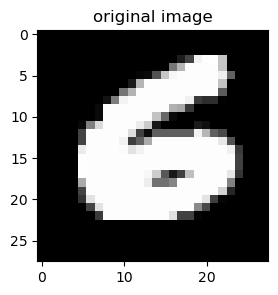

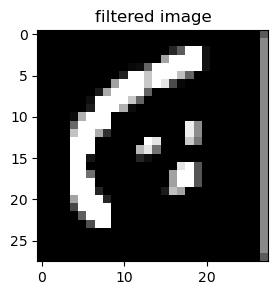

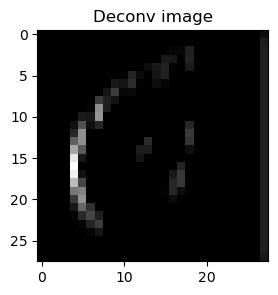

In [78]:
#| notest

# one image
x, y = dm.train_ds[0]
C, H, W = x.shape
# make fake batch dimension
x = x.unsqueeze(0)
print("x:", x.shape)
plt.figure(figsize=(3,3))
plt.imshow(x.squeeze(), cmap='gray')
plt.title("original image")

my_kernel = left_kernel

c = ConvLayer(1,3, kernel_size=3, stride=1)
with torch.no_grad():
    c.net[0].weight.copy_(my_kernel) # set kernel weights for convlayer 0 (actual convolution2d)

y = c(x)
print("y: ", y.shape)

plt.figure(figsize=(3,3))
plt.imshow(y.detach().squeeze().numpy().transpose(1, 2, 0), cmap='gray')
plt.title("filtered image")


dc = DeconvLayer(3, 1, stride=2, kernel_size=3)
with torch.no_grad():
    dc._net[1].weight.copy_(my_kernel) # set kernel weights for convlayer 1 (actual convolution2d)
x_bar = dc(y)
print("x_bar: ", x_bar.shape)
plt.figure(figsize=(3,3))
plt.imshow(x_bar.detach().squeeze(), cmap='gray')
plt.title("Deconv image")

## ConvNet
Simple convolution network for image recognition

In [ ]:
#| export

class ConvNet(nn.Module):

    def __init__(
            self,
            n_features:List[int]=[1, 8, 16, 32, 64], # channel/feature expansion
            num_classes:int=10, # num_classes
            kernel_size:int=3, # kernel size
            bias:bool=False, # conv2d bias
            normalization:nn.Module=nn.BatchNorm2d, # normalization (before activation)
            activation:nn.Module=nn.ReLU, # activation function
        ):

        super().__init__()

        net = []

        conv_stride_1 = ConvLayer(
            in_channels=n_features[0],
            out_channels=n_features[1],
            stride=1,
            kernel_size=kernel_size,
            bias=bias,
            normalization=normalization,
            activation=activation
        )
        net.append(conv_stride_1)

        for i in range(1, len(n_features) - 1):
            conv = ConvLayer(
                    in_channels=n_features[i],
                    out_channels=n_features[i+1],
                    kernel_size=kernel_size,
                    bias=bias,
                    normalization=normalization,
                    activation=activation
            )
            net.append(conv)
       
        net.append(
            ConvLayer(
                in_channels=n_features[-1],
                out_channels=num_classes,
                kernel_size=kernel_size,
                bias=True,
                normalization=None,
                activation=None
                )
            )
        net.append(nn.Flatten(start_dim=1, end_dim=-1))

        self.net = nn.Sequential(*net)


    def forward(
        self,
        x:torch.Tensor # input image tensor of dimension (B, C, W, H)
        ) -> torch.Tensor: # output probs (B, N_classes)
        return self.net(x)

In [ ]:
show_doc(ConvLayer, title_level=3)

---

[source](https://github.com/slegroux/nimrod/blob/main/nimrod/models/conv.py#L33){target="_blank" style="float:right; font-size:smaller"}

### ConvLayer

>      ConvLayer (in_channels:int=3, out_channels:int=16, kernel_size:int=3,
>                 stride:int=2, bias:bool=True, normalization:Optional[Type[torc
>                 h.nn.modules.module.Module]]=<class
>                 'torch.nn.modules.batchnorm.BatchNorm2d'>, activation:Optional
>                 [Type[torch.nn.modules.module.Module]]=<class
>                 'torch.nn.modules.activation.ReLU'>)

*A 2D convolutional layer with optional batch normalization and activation.

This layer performs 2D convolution with stride 2 for downsampling, optionally followed by
batch normalization and activation.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| in_channels | int | 3 | input channels |
| out_channels | int | 16 | output channels |
| kernel_size | int | 3 | kernel size |
| stride | int | 2 | stride |
| bias | bool | True | If True, adds a learnable bias to the convolution |
| normalization | Optional | BatchNorm2d | Normalization layer to use after convolution |
| activation | Optional | ReLU | Activation function to use after normalization |

### Usage

In [ ]:
B, C, H, W = 64, 1, 28, 28
X = torch.rand(B, C, H, W)
X.shape

torch.Size([64, 1, 28, 28])

In [ ]:
# model instantiation
convnet = ConvNet(
            n_features=[1, 8, 16, 32, 64, 128], # channel/feature expansion
            num_classes=10, # num_classes
            kernel_size=3, # kernel size
            bias=False, # conv2d bias
            normalization=nn.BatchNorm2d, # normalization (before activation)
            activation=nn.ReLU,
)
out = convnet(X)
print(out.shape)
print(summary(convnet, depth=4))
# from config
cfg = OmegaConf.load('../config/model/image/convnet.yaml')
# print(cfg.defaults)
# convnet = instantiate(cfg.defaults)
print(cfg.batchnorm)
convnet = instantiate(cfg.baseline)

# print(convnet(X).shape)

torch.Size([64, 10])
Layer (type:depth-idx)                   Param #
ConvNet                                  --
├─Sequential: 1-1                        --
│    └─ConvLayer: 2-1                    --
│    │    └─Sequential: 3-1              --
│    │    │    └─Conv2d: 4-1             72
│    │    │    └─BatchNorm2d: 4-2        16
│    │    │    └─ReLU: 4-3               --
│    └─ConvLayer: 2-2                    --
│    │    └─Sequential: 3-2              --
│    │    │    └─Conv2d: 4-4             1,152
│    │    │    └─BatchNorm2d: 4-5        32
│    │    │    └─ReLU: 4-6               --
│    └─ConvLayer: 2-3                    --
│    │    └─Sequential: 3-3              --
│    │    │    └─Conv2d: 4-7             4,608
│    │    │    └─BatchNorm2d: 4-8        64
│    │    │    └─ReLU: 4-9               --
│    └─ConvLayer: 2-4                    --
│    │    └─Sequential: 3-4              --
│    │    │    └─Conv2d: 4-10            18,432
│    │    │    └─BatchNorm2d: 4-11      

### Training

#### Dataloaders

In [ ]:
#| notest

# data module config
cfg = OmegaConf.load('../config/data/image/fashion_mnist.yaml')

BATCH_SIZE = 512
datamodule = instantiate(cfg, batch_size=BATCH_SIZE)
datamodule.prepare_data()
datamodule.setup()

# one data point 
X,y = datamodule.test_ds[0]
print("X (C,H,W): ", X.shape, "y: ", y)

# a batch of data via dataloader
XX,YY = next(iter(datamodule.test_dataloader()))
print("XX (B,C,H,W): ", XX.shape, "YY: ", YY.shape)

print(len(datamodule.train_ds))
print(len(datamodule.train_ds) // BATCH_SIZE)

[16:58:01] INFO - Init ImageDataModule for fashion_mnist


[16:58:15] INFO - split train into train/val [0.8, 0.2]
[16:58:15] INFO - train: 48000 val: 12000, test: 10000


X (C,H,W):  torch.Size([1, 32, 32]) y:  9
XX (B,C,H,W):  torch.Size([512, 1, 32, 32]) YY:  torch.Size([512])
48000
93


#### Model & hardware

In [ ]:
#| notest
device = get_device()
print(device)
cfg = OmegaConf.load('../config/model/image/convnet.yaml')
# print(cfg.defaults)
# convnet = instantiate(cfg.defaults)
print(cfg.baseline)
convnet = instantiate(cfg.baseline)
model = convnet.to(device)

summary(model, input_size=(B, C, H, W), depth=4)

[16:58:15] INFO - Using device: cuda


cuda
{'_target_': 'nimrod.models.conv.ConvNet', 'n_features': [1, 8, 16, 32, 64], 'num_classes': 10, 'kernel_size': 3, 'bias': True, 'normalization': None, 'activation': {'_target_': 'hydra.utils.get_class', 'path': 'torch.nn.ReLU'}}


Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [64, 10]                  --
├─Sequential: 1-1                        [64, 10]                  --
│    └─ConvLayer: 2-1                    [64, 8, 14, 14]           --
│    │    └─Sequential: 3-1              [64, 8, 14, 14]           --
│    │    │    └─Conv2d: 4-1             [64, 8, 14, 14]           80
│    │    │    └─ReLU: 4-2               [64, 8, 14, 14]           --
│    └─ConvLayer: 2-2                    [64, 16, 7, 7]            --
│    │    └─Sequential: 3-2              [64, 16, 7, 7]            --
│    │    │    └─Conv2d: 4-3             [64, 16, 7, 7]            1,168
│    │    │    └─ReLU: 4-4               [64, 16, 7, 7]            --
│    └─ConvLayer: 2-3                    [64, 32, 4, 4]            --
│    │    └─Sequential: 3-3              [64, 32, 4, 4]            --
│    │    │    └─Conv2d: 4-5             [64, 32, 4, 4]            4,640
│    │   

#### LR finder

Layer (type:depth-idx)                   Param #
ConvNet                                  --
├─Sequential: 1-1                        --
│    └─ConvLayer: 2-1                    --
│    │    └─Sequential: 3-1              --
│    │    │    └─Conv2d: 4-1             72
│    │    │    └─BatchNorm2d: 4-2        16
│    │    │    └─ReLU: 4-3               --
│    └─ConvLayer: 2-2                    --
│    │    └─Sequential: 3-2              --
│    │    │    └─Conv2d: 4-4             1,152
│    │    │    └─BatchNorm2d: 4-5        32
│    │    │    └─ReLU: 4-6               --
│    └─ConvLayer: 2-3                    --
│    │    └─Sequential: 3-3              --
│    │    │    └─Conv2d: 4-7             4,608
│    │    │    └─BatchNorm2d: 4-8        64
│    │    │    └─ReLU: 4-9               --
│    └─ConvLayer: 2-4                    --
│    │    └─Sequential: 3-4              --
│    │    │    └─Conv2d: 4-10            18,432
│    │    │    └─BatchNorm2d: 4-11       128
│    │    │    └

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.66E-03


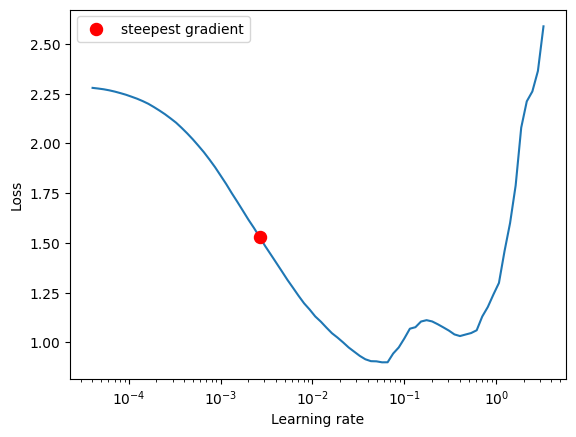

Suggested lr: 0.002656087782946686


In [ ]:
#| notest

cfg = OmegaConf.load('../config/model/image/convnet.yaml')
model = instantiate(cfg.batchnorm)
print(summary(model, depth=4))


criterion = nn.CrossEntropyLoss()    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) #, weight_decay=1e-5)
    
# Initialize LR Finder
lr_finder = LRFinder(model, optimizer, criterion, device=device)
    
# Run LR range test
lr_finder.range_test(
    datamodule.train_dataloader(),
    start_lr=1e-5,      # Extremely small starting learning rate
    end_lr=10,          # Large ending learning rate
    num_iter=100,   # Number of iterations to test
    smooth_f=0.05,   # Smoothing factor for the loss
    diverge_th=5, 
)
    
# Plot the learning rate vs loss
_, lr_found = lr_finder.plot(log_lr=True)
print('Suggested lr:', lr_found)
    
lr_finder.reset()
    

    

#### 1-cycle warm-up

[22:24:51] INFO - Init ImageDataModule for fashion_mnist


[22:24:59] INFO - split train into train/val [0.8, 0.2]
[22:24:59] INFO - train: 48000 val: 12000, test: 10000


cuda
size training set: 48000, bs: 512, steps/epoch: 93, total steps: 465
CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 5.01 μs
Loss 2.3470, Current LR: 0.0002659163, Step: 1/465
Epoch 1: Last training Loss 0.3637, Last Eval loss 0.3208 Accuracy = 86.98% Best Accuracy: 89.84
Loss 0.3831, Current LR: 0.0021199485, Step: 95/465
Epoch 2: Last training Loss 0.2433, Last Eval loss 0.2295 Accuracy = 89.87% Best Accuracy: 91.80
Loss 0.2716, Current LR: 0.0025014400, Step: 189/465
Epoch 3: Last training Loss 0.2054, Last Eval loss 0.1951 Accuracy = 90.92% Best Accuracy: 92.19
Loss 0.1860, Current LR: 0.0015607708, Step: 283/465
Epoch 4: Last training Loss 0.1976, Last Eval loss 0.1941 Accuracy = 91.68% Best Accuracy: 92.77
Loss 0.1703, Current LR: 0.0004413380, Step: 377/465
Reached total steps: 465/465
Epoch 5: Last training Loss 0.1558, Last Eval loss 0.1827 Accuracy = 91.88% Best Accuracy: 93.03


[<matplotlib.lines.Line2D>]

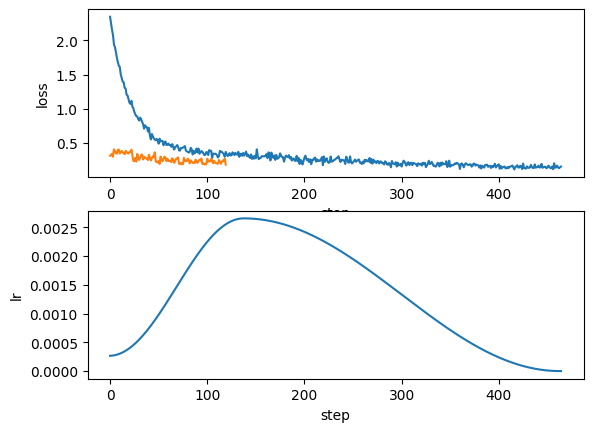

In [ ]:
#| notest

# data module config
cfg_dm = OmegaConf.load('../config/data/image/fashion_mnist.yaml')
cfg_dm.batch_size = 512
datamodule = instantiate(cfg_dm)
datamodule.prepare_data()
datamodule.setup()

# device = 'cpu'
print(device)
cfg_mdl = OmegaConf.load('../config/model/image/convnet.yaml')
convnet = instantiate(cfg_mdl.batchnorm)
model = convnet.to(device)

N_EPOCHS = 5

# lr_found = 7e-3 # from lr finder

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
steps_per_epoch = len(datamodule.train_ds) // cfg_dm.batch_size
total_steps = steps_per_epoch* N_EPOCHS
print(f"size training set: {len(datamodule.train_ds)}, bs: {cfg_dm.batch_size}, steps/epoch: {steps_per_epoch}, total steps: {total_steps}")
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=steps_per_epochs, epochs=1)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr_found,  # Peak learning rate
        # total_steps=len(datamodule.train_ds) * N_EPOCHS,  # Total training iterations
        steps_per_epoch=steps_per_epoch,
        epochs=N_EPOCHS,
        pct_start=0.3,  # 30% of training increasing LR, 70% decreasing
        anneal_strategy='cos',  # Cosine annealing
        div_factor=10,  # Initial lr = max_lr / div_factor
        # final_div_factor=1e4,
        three_phase=False  # Two phase LR schedule (increase then decrease)
    )

################################
%time

lrs = []
current_step = 0
train_loss_history = []
eval_loss_history = []
avg_train_loss_hist = []
avg_eval_loss_hist = []
max_acc = 0

for epoch in range(N_EPOCHS):
    i = 0
    model.train()
    for images, labels in datamodule.train_dataloader():
        if current_step >= total_steps:
            print(f"Reached total steps: {current_step}/{total_steps}")
            break
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()
        scheduler.step()    
        current_step += 1
        train_loss_history.append(loss.item())
        # current_lr = scheduler.get_last_lr()[0]
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        if not (i % 100):
            print(f"Loss {loss.item():.4f}, Current LR: {current_lr:.10f}, Step: {current_step}/{total_steps}")
        i += 1

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in datamodule.val_dataloader():
            # model expects input (B,H*W)
            images = images.to(device)
            labels = labels.to(device)
            # Pass the input through the model
            outputs = model(images)
            # eval loss
            eval_loss = criterion(outputs, labels)
            eval_loss_history.append(eval_loss.item())
            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update the total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum()
            acc = 100 * correct / total
            if acc > max_acc:
                max_acc = acc

        # Print the accuracy
    print(f"Epoch {epoch + 1}: Last training Loss {loss.item():.4f}, Last Eval loss {eval_loss.item():.4f} Accuracy = {100 * correct / total:.2f}% Best Accuracy: {max_acc:.2f}")
    # print(f'Current LR: {optimizer.param_groups[0]["lr"]:.5f}')

###################
plt.figure(1)
plt.subplot(211)
plt.ylabel('loss')
plt.xlabel('step')
plt.plot(train_loss_history)
plt.plot(eval_loss_history)
plt.subplot(212)
plt.ylabel('lr')
plt.xlabel('step')
plt.plot(lrs)



## ConvNetX

In [ ]:
#| export

class ConvNetX(Classifier, LightningModule):
    def __init__(
            self,
            nnet:ConvNet,
            num_classes:int,
            optimizer:torch.optim.Optimizer,
            scheduler:torch.optim.lr_scheduler,
            ):
        logger.info("ConvNetX: init")
        super().__init__(num_classes, optimizer, scheduler)
        self.register_module('nnet', nnet)
        self.save_hyperparameters(logger=False, ignore=['nnet']) # by default saved since input of __init__
        self.lr = optimizer.keywords['lr'] # for lr finder
        self.nnet = nnet

    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.nnet(x)
    
    def _step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        preds = y_hat.argmax(dim=1)
        return loss, preds, y
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.forward(x)
        return y_hat.argmax(dim=1)

### Usage

In [80]:
cfg = OmegaConf.load('../config/model/image/convnetx.yaml')
model = instantiate(cfg)

[15:29:02] INFO - ConvNetX: init
[15:29:02] INFO - Classifier: init


In [81]:
B, C, H, W = 64, 1, 28, 28
X = torch.rand(B, C, H, W)
X.shape
print(model(X).shape)

torch.Size([64, 40])


In [82]:
summary(model, input_size=(B, C, H, W), depth=5)

Layer (type:depth-idx)                        Output Shape              Param #
ConvNetX                                      [64, 40]                  --
├─ConvNet: 1-1                                [64, 40]                  --
│    └─Sequential: 2-1                        [64, 40]                  --
│    │    └─ConvLayer: 3-1                    [64, 8, 28, 28]           --
│    │    │    └─Sequential: 4-1              [64, 8, 28, 28]           --
│    │    │    │    └─Conv2d: 5-1             [64, 8, 28, 28]           72
│    │    │    │    └─BatchNorm2d: 5-2        [64, 8, 28, 28]           16
│    │    │    │    └─ReLU: 5-3               [64, 8, 28, 28]           --
│    │    └─ConvLayer: 3-2                    [64, 16, 14, 14]          --
│    │    │    └─Sequential: 4-2              [64, 16, 14, 14]          --
│    │    │    │    └─Conv2d: 5-4             [64, 16, 14, 14]          1,152
│    │    │    │    └─BatchNorm2d: 5-5        [64, 16, 14, 14]          32
│    │    │    │ 

### Nimrod training

In [ ]:
#| notest

# data module config
cfg = OmegaConf.load('../config/data/image/mnist.yaml')
cfg.batch_size = 512
cfg.num_workers = 0
datamodule = instantiate(cfg)
datamodule.prepare_data()
datamodule.setup()

[18:25:38] INFO - Init ImageDataModule for mnist
[18:25:54] INFO - split train into train/val [0.8, 0.2]
[18:25:54] INFO - train: 48000 val: 12000, test: 10000


In [ ]:
#| notest
N_EPOCHS = 5

trainer = Trainer(
    accelerator="auto",
    max_epochs=N_EPOCHS,
    logger=TensorBoardLogger("tb_logs", name="mnist_convnet", default_hp_metric=True),
    # logger=CSVLogger("logs", name="mnist_convnet"),
    callbacks = [LearningRateMonitor(logging_interval="step")],
    check_val_every_n_epoch=1,
    log_every_n_steps=1
    )


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


#### LR finder

[13:35:46] INFO - mnist Dataset: init
[13:35:51] INFO - mnist Dataset: init
[13:35:54] INFO - Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
[13:35:54] INFO - Scheduler: <torch.optim.lr_scheduler.OneCycleLR object>
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:316: The lr scheduler dict contains the key(s) ['monitor', 'strict'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve perfor

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.012022644346174135
Restoring states from the checkpoint path at /Users/slegroux/Projects/nimrod/nbs/.lr_find_c5598ba7-33b0-4845-a7c2-c94e6a45fa15.ckpt
Restored all states from the checkpoint at /Users/slegroux/Projects/nimrod/nbs/.lr_find_c5598ba7-33b0-4845-a7c2-c94e6a45fa15.ckpt


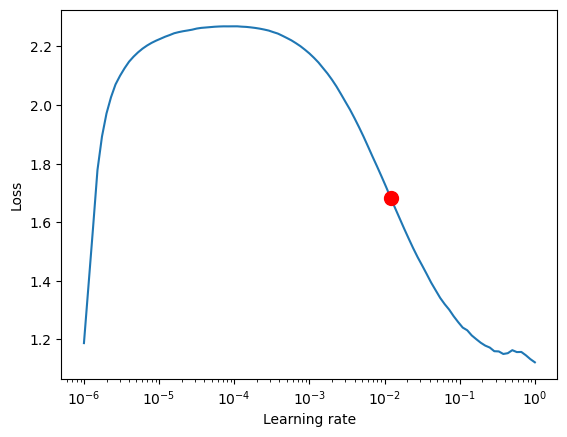

Suggested learning rate: 0.012022644346174135


In [ ]:
#| notest

tuner = Tuner(trainer)
lr_finder = tuner.lr_find(
    model,
    datamodule=datamodule,
    min_lr=1e-6,
    max_lr=1.0,
    num_training=100,  # number of iterations
    # attr_name="optimizer.lr",
)
fig = lr_finder.plot(suggest=True)
plt.show()
print(f"Suggested learning rate: {lr_finder.suggestion()}")

In [ ]:
#| notest
print(trainer.max_epochs, len(datamodule.train_ds), datamodule.hparams.batch_size)
print(5*56000)
print(5*56000/2048)
print(5*56000//2048)

10 48000 512
280000
136.71875
136


#### 1-cycle scheduling

In [5]:
#| notest

N_EPOCHS = 5
lr_found = 0.012

# DATA
cfg = OmegaConf.load('../config/data/image/mnist.yaml')
cfg.batch_size = 512
cfg.num_workers = 0
datamodule = instantiate(cfg)
datamodule.prepare_data()
datamodule.setup()

checkpoint_callback = ModelCheckpoint(
    monitor='val/loss',  # Metric to monitor
    dirpath='checkpoints/',  # Directory to save checkpoints
    filename='epoch{epoch:02d}-val_loss{val/loss:.2f}',
    auto_insert_metric_name=False,
    save_top_k=1,  # Save only the best checkpoint
    mode='min'  # Mode can be 'min' or 'max' depending on the metric
)

# TRAINER 
trainer = Trainer(
    accelerator="auto",
    max_epochs=N_EPOCHS,
    # logger=TensorBoardLogger("tb_logs", name="mnist_convnet", default_hp_metric=True),
    logger=CSVLogger("logs", name="mnist_convnet"),
    callbacks = [LearningRateMonitor(logging_interval="step"), checkpoint_callback],
    check_val_every_n_epoch=1,
    log_every_n_steps=1
    )

print("estimated steps: ", trainer.estimated_stepping_batches, "accumulate_grad_batches: ", trainer.accumulate_grad_batches)

# MODEL
model_cfg = OmegaConf.load('../config/model/image/convnetx.yaml')

steps_per_epoch = len(datamodule.train_ds) // cfg.batch_size // trainer.accumulate_grad_batches #accumulate = 1 when not on
print("Steps per epoch: ", steps_per_epoch)

# model_cfg.scheduler.epochs = N_EPOCHS 
model_cfg.scheduler.total_steps = trainer.max_epochs * steps_per_epoch
model_cfg.scheduler.max_lr = lr_found#lr_finder.suggestion()

model = instantiate(model_cfg)

print("LR: ",model.lr)
trainer.fit(model, datamodule.train_dataloader(), datamodule.val_dataloader())

########################
csv_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(csv_path)
metrics.head()

##########################
plt.figure()
plt.plot(metrics['step'], metrics['train/loss_step'], 'b.-')
plt.plot(metrics['step'], metrics['val/loss'],'r.-')
plt.figure()
plt.plot(metrics['step'], metrics['lr-Adam'], 'g.-')
plt.show()

[22:28:16] INFO - PyTorch version 2.5.1 available.
Seed set to 42
[22:28:20] INFO - Init ImageDataModule for mnist
[22:28:38] INFO - split train into train/val [0.8, 0.2]
[22:28:38] INFO - train: 48000 val: 12000, test: 10000
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.
Seed set to 42
[22:28:38] INFO - ConvNetX: init
[22:28:38] INFO - Classifier: init
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/slegroux/Projects/nimrod/nbs/checkpoints exists and is not empty.
[22:28:38] INFO - Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

  | Name         | Type               | Pa

estimated steps:  -1 accumulate_grad_batches:  1
Steps per epoch:  93
LR:  0.0001


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


RuntimeError: Detected more unique values in `preds` than expected. Expected only 10 but found 12 in `preds`. Found values: tensor([ 5,  6,  7,  8,  9, 10, 11, 13, 28, 31, 33, 34], device='mps:0').

In [ ]:
#| notest
trainer.test(model, datamodule.test_dataloader(), ckpt_path="best")

Restoring states from the checkpoint path at /Users/slegroux/Projects/nimrod/nbs/checkpoints/epoch04-val_loss0.04.ckpt
Loaded model weights from the checkpoint at /Users/slegroux/Projects/nimrod/nbs/checkpoints/epoch04-val_loss0.04.ckpt
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9897000193595886     │
│         test/loss         │   0.029618283733725548    │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.029618283733725548, 'test/acc': 0.9897000193595886}]

In [ ]:
#| notest
best_checkpoint_path = checkpoint_callback.best_model_path
print(f"Best checkpoint path: {best_checkpoint_path}")

Best checkpoint path: /Users/slegroux/Projects/nimrod/nbs/checkpoints/epoch04-val_loss0.04.ckpt


#### Resume training

In [2]:
#| notest

cfg = OmegaConf.load('../config/model/image/convnetx_adam.yaml')
sched = instantiate(cfg.scheduler)
model = ConvNetX.load_from_checkpoint(best_checkpoint_path, lr=0.1, scheduler=sched)

pprint(model.hparams)

NameError: name 'OmegaConf' is not defined

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /Users/slegroux/Projects/nimrod/nbs/checkpoints/epoch04-val_loss0.04.ckpt
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:273: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': 'val/loss', 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None}"].
[19:13:20] INFO - Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
[19:13:20] INFO - Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object>
/Users/slegroux/miniforge3

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


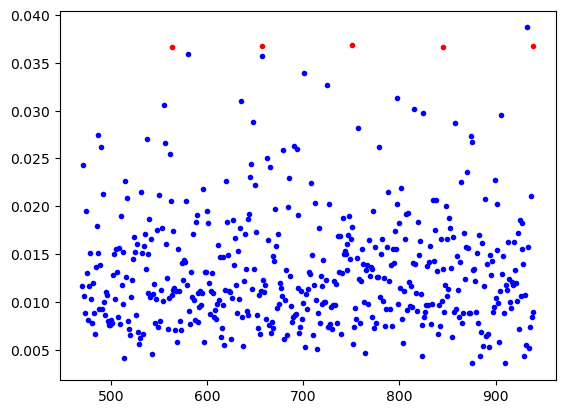

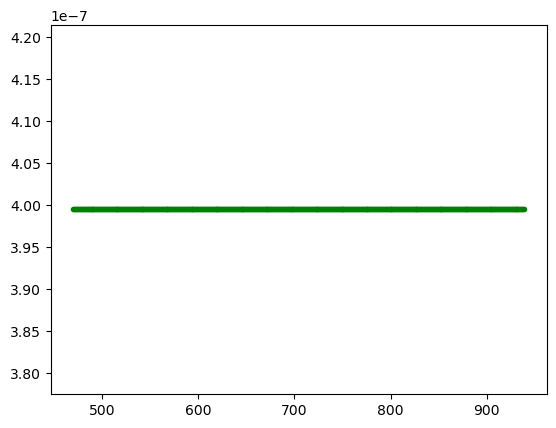

Restoring states from the checkpoint path at logs/mnist_convnet/version_62/checkpoints/epoch=9-step=935.ckpt
Loaded model weights from the checkpoint at logs/mnist_convnet/version_62/checkpoints/epoch=9-step=935.ckpt
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9896000027656555     │
│         test/loss         │   0.029625719413161278    │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.029625719413161278, 'test/acc': 0.9896000027656555}]

In [ ]:
#| notest
# batchnorm should allow us to try higher LR
# model_cfg = OmegaConf.load('../config/model/image/convnetx_adam.yaml')
# model_cfg.optimizer.lr = 0.1

# model = instantiate(model_cfg)
# opt = instantiate(model_cfg.optimizer)
# print(opt)
# sched = instantiate(model_cfg.scheduler)
# print(sched)


N_EPOCHS = 10

trainer = Trainer(
    accelerator="auto",
    max_epochs=N_EPOCHS,
    # logger=TensorBoardLogger("tb_logs", name="mnist_convnet", default_hp_metric=True),
    logger=CSVLogger("logs", name="mnist_convnet"),
    callbacks = [LearningRateMonitor(logging_interval="step")],
    check_val_every_n_epoch=1,
    log_every_n_steps=1
    )

# use standar adam scheduler

# retrieve last ckpt
trainer.fit(model, datamodule.train_dataloader(), datamodule.val_dataloader(), ckpt_path=best_checkpoint_path)

##############################
#| notest
csv_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(csv_path)
metrics.head()
plt.figure()
plt.plot(metrics['step'], metrics['train/loss_step'], 'b.-')
plt.plot(metrics['step'], metrics['val/loss'],'r.-')
plt.figure()
plt.plot(metrics['step'], metrics['lr-Adam'], 'g.-')
plt.show()
trainer.test(model, datamodule.test_dataloader(), ckpt_path="best")


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()